In [62]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2448, 4) (1074, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 61s 61s/step - loss: 15041.9053
Epoch 2/4000
1/1 [==============================] - 0s 23ms/step - loss: 14958.0684
Epoch 3/4000
1/1 [==============================] - 0s 18ms/step - loss: 14899.4004
Epoch 4/4000
1/1 [==============================] - 0s 21ms/step - loss: 14851.1484
Epoch 5/4000
1/1 [==============================] - 0s 19ms/step - loss: 14808.7617
Epoch 6/4000
1/1 [==============================] - 0s 18ms/step - loss: 14770.1777
Epoch 7/4000
1/1 [==============================] - 0s 17ms/step - loss: 14734.2861
Epoch 8/4000
1/1 [==============================] - 0s 18ms/step - loss: 14700.3984
Epoch 9/4000
1/1 [==============================] - 0s 19ms/step - loss: 14668.0586
Epoch 10/4000
1/1 [==============================] - 0s 17ms/step - loss: 14636.9629
Epoch 11/4000
1/1 [==============================] - 0s 17ms/step - loss: 14606.8906
Epoch 12/4000
1/1 [==============================] - 0s 18ms/step - loss: 

1/1 [==============================] - 0s 24ms/step - loss: 13031.8750
Epoch 98/4000
1/1 [==============================] - 0s 24ms/step - loss: 13019.4902
Epoch 99/4000
1/1 [==============================] - 0s 24ms/step - loss: 13007.1846
Epoch 100/4000
1/1 [==============================] - 0s 24ms/step - loss: 12994.9609
Epoch 101/4000
1/1 [==============================] - 0s 24ms/step - loss: 12982.8174
Epoch 102/4000
1/1 [==============================] - 0s 24ms/step - loss: 12970.7520
Epoch 103/4000
1/1 [==============================] - 0s 25ms/step - loss: 12958.7617
Epoch 104/4000
1/1 [==============================] - 0s 24ms/step - loss: 12946.8516
Epoch 105/4000
1/1 [==============================] - 0s 24ms/step - loss: 12935.0156
Epoch 106/4000
1/1 [==============================] - 0s 24ms/step - loss: 12923.2539
Epoch 107/4000
1/1 [==============================] - 0s 24ms/step - loss: 12911.5645
Epoch 108/4000
1/1 [==============================] - 0s 24ms/step - lo

1/1 [==============================] - 0s 31ms/step - loss: 12117.4844
Epoch 193/4000
1/1 [==============================] - 0s 28ms/step - loss: 12109.8721
Epoch 194/4000
1/1 [==============================] - 0s 24ms/step - loss: 12102.2881
Epoch 195/4000
1/1 [==============================] - 0s 24ms/step - loss: 12094.7334
Epoch 196/4000
1/1 [==============================] - 0s 23ms/step - loss: 12087.2090
Epoch 197/4000
1/1 [==============================] - 0s 23ms/step - loss: 12079.7129
Epoch 198/4000
1/1 [==============================] - 0s 23ms/step - loss: 12072.2461
Epoch 199/4000
1/1 [==============================] - 0s 23ms/step - loss: 12064.8086
Epoch 200/4000
1/1 [==============================] - 0s 23ms/step - loss: 12057.3965
Epoch 201/4000
1/1 [==============================] - 0s 23ms/step - loss: 12050.0156
Epoch 202/4000
1/1 [==============================] - 0s 23ms/step - loss: 12042.6611
Epoch 203/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 11499.2744
Epoch 288/4000
1/1 [==============================] - 0s 23ms/step - loss: 11493.6562
Epoch 289/4000
1/1 [==============================] - 0s 23ms/step - loss: 11488.0527
Epoch 290/4000
1/1 [==============================] - 0s 23ms/step - loss: 11482.4609
Epoch 291/4000
1/1 [==============================] - 0s 22ms/step - loss: 11476.8867
Epoch 292/4000
1/1 [==============================] - 0s 23ms/step - loss: 11471.3242
Epoch 293/4000
1/1 [==============================] - 0s 23ms/step - loss: 11465.7734
Epoch 294/4000
1/1 [==============================] - 0s 23ms/step - loss: 11460.2402
Epoch 295/4000
1/1 [==============================] - 0s 23ms/step - loss: 11454.7188
Epoch 296/4000
1/1 [==============================] - 0s 23ms/step - loss: 11449.2109
Epoch 297/4000
1/1 [==============================] - 0s 23ms/step - loss: 11443.7148
Epoch 298/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 10848.3008
Epoch 383/4000
1/1 [==============================] - 0s 23ms/step - loss: 10840.5967
Epoch 384/4000
1/1 [==============================] - 0s 23ms/step - loss: 10832.9043
Epoch 385/4000
1/1 [==============================] - 0s 23ms/step - loss: 10825.2285
Epoch 386/4000
1/1 [==============================] - 0s 23ms/step - loss: 10817.5654
Epoch 387/4000
1/1 [==============================] - 0s 23ms/step - loss: 10809.9141
Epoch 388/4000
1/1 [==============================] - 0s 22ms/step - loss: 10802.2773
Epoch 389/4000
1/1 [==============================] - 0s 23ms/step - loss: 10794.6533
Epoch 390/4000
1/1 [==============================] - 0s 23ms/step - loss: 10787.0420
Epoch 391/4000
1/1 [==============================] - 0s 23ms/step - loss: 10779.4434
Epoch 392/4000
1/1 [==============================] - 0s 23ms/step - loss: 10771.8574
Epoch 393/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 10122.8047
Epoch 478/4000
1/1 [==============================] - 0s 24ms/step - loss: 10115.2891
Epoch 479/4000
1/1 [==============================] - 0s 23ms/step - loss: 10107.7939
Epoch 480/4000
1/1 [==============================] - 0s 25ms/step - loss: 10100.3164
Epoch 481/4000
1/1 [==============================] - 0s 23ms/step - loss: 10092.8594
Epoch 482/4000
1/1 [==============================] - 0s 24ms/step - loss: 10085.4199
Epoch 483/4000
1/1 [==============================] - 0s 24ms/step - loss: 10078.0000
Epoch 484/4000
1/1 [==============================] - 0s 24ms/step - loss: 10070.5967
Epoch 485/4000
1/1 [==============================] - 0s 25ms/step - loss: 10063.2100
Epoch 486/4000
1/1 [==============================] - 0s 24ms/step - loss: 10055.8379
Epoch 487/4000
1/1 [==============================] - 0s 24ms/step - loss: 10048.4863
Epoch 488/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 9463.4453
Epoch 574/4000
1/1 [==============================] - 0s 23ms/step - loss: 9457.1719
Epoch 575/4000
1/1 [==============================] - 0s 23ms/step - loss: 9450.9102
Epoch 576/4000
1/1 [==============================] - 0s 23ms/step - loss: 9444.6631
Epoch 577/4000
1/1 [==============================] - 0s 23ms/step - loss: 9438.4277
Epoch 578/4000
1/1 [==============================] - 0s 23ms/step - loss: 9432.2061
Epoch 579/4000
1/1 [==============================] - 0s 23ms/step - loss: 9425.9961
Epoch 580/4000
1/1 [==============================] - 0s 23ms/step - loss: 9419.7998
Epoch 581/4000
1/1 [==============================] - 0s 23ms/step - loss: 9413.6162
Epoch 582/4000
1/1 [==============================] - 0s 23ms/step - loss: 9407.4434
Epoch 583/4000
1/1 [==============================] - 0s 24ms/step - loss: 9401.2842
Epoch 584/4000
1/1 [==============================] - 0s 23ms/step - loss: 9395.

1/1 [==============================] - 0s 24ms/step - loss: 8912.1123
Epoch 670/4000
1/1 [==============================] - 0s 24ms/step - loss: 8906.8594
Epoch 671/4000
1/1 [==============================] - 0s 24ms/step - loss: 8901.6152
Epoch 672/4000
1/1 [==============================] - 0s 24ms/step - loss: 8896.3828
Epoch 673/4000
1/1 [==============================] - 0s 24ms/step - loss: 8891.1582
Epoch 674/4000
1/1 [==============================] - 0s 24ms/step - loss: 8885.9453
Epoch 675/4000
1/1 [==============================] - 0s 23ms/step - loss: 8880.7422
Epoch 676/4000
1/1 [==============================] - 0s 23ms/step - loss: 8875.5488
Epoch 677/4000
1/1 [==============================] - 0s 24ms/step - loss: 8870.3662
Epoch 678/4000
1/1 [==============================] - 0s 23ms/step - loss: 8865.1934
Epoch 679/4000
1/1 [==============================] - 0s 23ms/step - loss: 8860.0303
Epoch 680/4000
1/1 [==============================] - 0s 23ms/step - loss: 8854.

1/1 [==============================] - 0s 23ms/step - loss: 8449.9219
Epoch 766/4000
1/1 [==============================] - 0s 23ms/step - loss: 8445.4961
Epoch 767/4000
1/1 [==============================] - 0s 23ms/step - loss: 8441.0898
Epoch 768/4000
1/1 [==============================] - 0s 23ms/step - loss: 8436.6758
Epoch 769/4000
1/1 [==============================] - 0s 23ms/step - loss: 8432.2852
Epoch 770/4000
1/1 [==============================] - 0s 24ms/step - loss: 8427.8857
Epoch 771/4000
1/1 [==============================] - 0s 23ms/step - loss: 8423.5088
Epoch 772/4000
1/1 [==============================] - 0s 23ms/step - loss: 8419.1221
Epoch 773/4000
1/1 [==============================] - 0s 23ms/step - loss: 8414.7598
Epoch 774/4000
1/1 [==============================] - 0s 23ms/step - loss: 8410.3877
Epoch 775/4000
1/1 [==============================] - 0s 34ms/step - loss: 8406.0381
Epoch 776/4000
1/1 [==============================] - 0s 30ms/step - loss: 8401.

1/1 [==============================] - 0s 29ms/step - loss: 8057.0586
Epoch 862/4000
1/1 [==============================] - 0s 31ms/step - loss: 8053.2988
Epoch 863/4000
1/1 [==============================] - 0s 30ms/step - loss: 8049.5762
Epoch 864/4000
1/1 [==============================] - 0s 31ms/step - loss: 8045.8311
Epoch 865/4000
1/1 [==============================] - 0s 28ms/step - loss: 8042.1235
Epoch 866/4000
1/1 [==============================] - 0s 34ms/step - loss: 8038.3931
Epoch 867/4000
1/1 [==============================] - 0s 29ms/step - loss: 8034.7002
Epoch 868/4000
1/1 [==============================] - 0s 31ms/step - loss: 8030.9839
Epoch 869/4000
1/1 [==============================] - 0s 27ms/step - loss: 8027.3057
Epoch 870/4000
1/1 [==============================] - 0s 27ms/step - loss: 8023.6030
Epoch 871/4000
1/1 [==============================] - 0s 26ms/step - loss: 8019.9395
Epoch 872/4000
1/1 [==============================] - 0s 27ms/step - loss: 8016.

1/1 [==============================] - 0s 23ms/step - loss: 7727.3359
Epoch 958/4000
1/1 [==============================] - 0s 23ms/step - loss: 7724.1626
Epoch 959/4000
1/1 [==============================] - 0s 23ms/step - loss: 7721.0244
Epoch 960/4000
1/1 [==============================] - 0s 23ms/step - loss: 7717.8618
Epoch 961/4000
1/1 [==============================] - 0s 25ms/step - loss: 7714.7339
Epoch 962/4000
1/1 [==============================] - 0s 24ms/step - loss: 7711.5811
Epoch 963/4000
1/1 [==============================] - 0s 23ms/step - loss: 7708.4639
Epoch 964/4000
1/1 [==============================] - 0s 23ms/step - loss: 7705.3213
Epoch 965/4000
1/1 [==============================] - 0s 23ms/step - loss: 7702.2134
Epoch 966/4000
1/1 [==============================] - 0s 23ms/step - loss: 7699.0825
Epoch 967/4000
1/1 [==============================] - 0s 23ms/step - loss: 7695.9854
Epoch 968/4000
1/1 [==============================] - 0s 23ms/step - loss: 7692.

Epoch 1053/4000
1/1 [==============================] - 0s 23ms/step - loss: 7451.4663
Epoch 1054/4000
1/1 [==============================] - 0s 23ms/step - loss: 7448.8906
Epoch 1055/4000
1/1 [==============================] - 0s 23ms/step - loss: 7446.3462
Epoch 1056/4000
1/1 [==============================] - 0s 23ms/step - loss: 7443.7739
Epoch 1057/4000
1/1 [==============================] - 0s 23ms/step - loss: 7441.2378
Epoch 1058/4000
1/1 [==============================] - 0s 23ms/step - loss: 7438.6714
Epoch 1059/4000
1/1 [==============================] - 0s 23ms/step - loss: 7436.1436
Epoch 1060/4000
1/1 [==============================] - 0s 23ms/step - loss: 7433.5972
Epoch 1061/4000
1/1 [==============================] - 0s 23ms/step - loss: 7431.0864
Epoch 1062/4000
1/1 [==============================] - 0s 23ms/step - loss: 7428.5688
Epoch 1063/4000
1/1 [==============================] - 0s 23ms/step - loss: 7426.0645
Epoch 1064/4000
1/1 [==============================] -

1/1 [==============================] - 0s 24ms/step - loss: 7233.9102
Epoch 1149/4000
1/1 [==============================] - 0s 24ms/step - loss: 7231.9141
Epoch 1150/4000
1/1 [==============================] - 0s 24ms/step - loss: 7229.8838
Epoch 1151/4000
1/1 [==============================] - 0s 24ms/step - loss: 7227.9043
Epoch 1152/4000
1/1 [==============================] - 0s 24ms/step - loss: 7225.9028
Epoch 1153/4000
1/1 [==============================] - 0s 24ms/step - loss: 7223.9404
Epoch 1154/4000
1/1 [==============================] - 0s 24ms/step - loss: 7221.9590
Epoch 1155/4000
1/1 [==============================] - 0s 24ms/step - loss: 7219.9888
Epoch 1156/4000
1/1 [==============================] - 0s 23ms/step - loss: 7218.0098
Epoch 1157/4000
1/1 [==============================] - 0s 24ms/step - loss: 7216.0425
Epoch 1158/4000
1/1 [==============================] - 0s 24ms/step - loss: 7214.0703
Epoch 1159/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 7066.9565
Epoch 1244/4000
1/1 [==============================] - 0s 24ms/step - loss: 7065.4126
Epoch 1245/4000
1/1 [==============================] - 0s 24ms/step - loss: 7063.9312
Epoch 1246/4000
1/1 [==============================] - 0s 24ms/step - loss: 7062.4238
Epoch 1247/4000
1/1 [==============================] - 0s 23ms/step - loss: 7060.9443
Epoch 1248/4000
1/1 [==============================] - 0s 26ms/step - loss: 7059.4282
Epoch 1249/4000
1/1 [==============================] - 0s 24ms/step - loss: 7057.9248
Epoch 1250/4000
1/1 [==============================] - 0s 26ms/step - loss: 7056.3965
Epoch 1251/4000
1/1 [==============================] - 0s 24ms/step - loss: 7054.9043
Epoch 1252/4000
1/1 [==============================] - 0s 26ms/step - loss: 7053.3945
Epoch 1253/4000
1/1 [==============================] - 0s 24ms/step - loss: 7051.9419
Epoch 1254/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6940.5024
Epoch 1339/4000
1/1 [==============================] - 0s 23ms/step - loss: 6939.3965
Epoch 1340/4000
1/1 [==============================] - 0s 23ms/step - loss: 6938.2114
Epoch 1341/4000
1/1 [==============================] - 0s 24ms/step - loss: 6937.1514
Epoch 1342/4000
1/1 [==============================] - 0s 24ms/step - loss: 6936.0474
Epoch 1343/4000
1/1 [==============================] - 0s 24ms/step - loss: 6934.9614
Epoch 1344/4000
1/1 [==============================] - 0s 25ms/step - loss: 6933.8237
Epoch 1345/4000
1/1 [==============================] - 0s 23ms/step - loss: 6932.6636
Epoch 1346/4000
1/1 [==============================] - 0s 24ms/step - loss: 6931.4951
Epoch 1347/4000
1/1 [==============================] - 0s 23ms/step - loss: 6930.3740
Epoch 1348/4000
1/1 [==============================] - 0s 26ms/step - loss: 6929.2437
Epoch 1349/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6847.5278
Epoch 1434/4000
1/1 [==============================] - 0s 23ms/step - loss: 6846.5195
Epoch 1435/4000
1/1 [==============================] - 0s 23ms/step - loss: 6845.7129
Epoch 1436/4000
1/1 [==============================] - 0s 23ms/step - loss: 6844.8135
Epoch 1437/4000
1/1 [==============================] - 0s 23ms/step - loss: 6844.1016
Epoch 1438/4000
1/1 [==============================] - 0s 23ms/step - loss: 6843.3418
Epoch 1439/4000
1/1 [==============================] - 0s 23ms/step - loss: 6842.6548
Epoch 1440/4000
1/1 [==============================] - 0s 22ms/step - loss: 6841.8340
Epoch 1441/4000
1/1 [==============================] - 0s 23ms/step - loss: 6840.9199
Epoch 1442/4000
1/1 [==============================] - 0s 23ms/step - loss: 6839.9907
Epoch 1443/4000
1/1 [==============================] - 0s 23ms/step - loss: 6839.1113
Epoch 1444/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6778.6982
Epoch 1529/4000
1/1 [==============================] - 0s 23ms/step - loss: 6778.3096
Epoch 1530/4000
1/1 [==============================] - 0s 23ms/step - loss: 6777.6616
Epoch 1531/4000
1/1 [==============================] - 0s 23ms/step - loss: 6777.2227
Epoch 1532/4000
1/1 [==============================] - 0s 23ms/step - loss: 6776.3301
Epoch 1533/4000
1/1 [==============================] - 0s 23ms/step - loss: 6775.6914
Epoch 1534/4000
1/1 [==============================] - 0s 23ms/step - loss: 6774.8511
Epoch 1535/4000
1/1 [==============================] - 0s 23ms/step - loss: 6774.2334
Epoch 1536/4000
1/1 [==============================] - 0s 23ms/step - loss: 6773.7197
Epoch 1537/4000
1/1 [==============================] - 0s 23ms/step - loss: 6773.3677
Epoch 1538/4000
1/1 [==============================] - 0s 23ms/step - loss: 6772.7559
Epoch 1539/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6726.1865
Epoch 1624/4000
1/1 [==============================] - 0s 25ms/step - loss: 6725.9258
Epoch 1625/4000
1/1 [==============================] - 0s 26ms/step - loss: 6725.2554
Epoch 1626/4000
1/1 [==============================] - 0s 23ms/step - loss: 6724.6260
Epoch 1627/4000
1/1 [==============================] - 0s 23ms/step - loss: 6723.5098
Epoch 1628/4000
1/1 [==============================] - 0s 23ms/step - loss: 6723.3940
Epoch 1629/4000
1/1 [==============================] - 0s 23ms/step - loss: 6722.5234
Epoch 1630/4000
1/1 [==============================] - 0s 23ms/step - loss: 6722.5039
Epoch 1631/4000
1/1 [==============================] - 0s 23ms/step - loss: 6722.4370
Epoch 1632/4000
1/1 [==============================] - 0s 23ms/step - loss: 6721.7427
Epoch 1633/4000
1/1 [==============================] - 0s 22ms/step - loss: 6721.3086
Epoch 1634/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6682.5957
Epoch 1719/4000
1/1 [==============================] - 0s 24ms/step - loss: 6681.8760
Epoch 1720/4000
1/1 [==============================] - 0s 24ms/step - loss: 6682.1152
Epoch 1721/4000
1/1 [==============================] - 0s 24ms/step - loss: 6681.8013
Epoch 1722/4000
1/1 [==============================] - 0s 23ms/step - loss: 6681.9976
Epoch 1723/4000
1/1 [==============================] - 0s 24ms/step - loss: 6681.6172
Epoch 1724/4000
1/1 [==============================] - 0s 24ms/step - loss: 6680.5117
Epoch 1725/4000
1/1 [==============================] - 0s 25ms/step - loss: 6680.0679
Epoch 1726/4000
1/1 [==============================] - 0s 24ms/step - loss: 6679.0903
Epoch 1727/4000
1/1 [==============================] - 0s 24ms/step - loss: 6679.8008
Epoch 1728/4000
1/1 [==============================] - 0s 25ms/step - loss: 6678.6172
Epoch 1729/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6646.9458
Epoch 1814/4000
1/1 [==============================] - 0s 23ms/step - loss: 6647.7915
Epoch 1815/4000
1/1 [==============================] - 0s 23ms/step - loss: 6646.6924
Epoch 1816/4000
1/1 [==============================] - 0s 23ms/step - loss: 6646.1953
Epoch 1817/4000
1/1 [==============================] - 0s 23ms/step - loss: 6645.2783
Epoch 1818/4000
1/1 [==============================] - 0s 23ms/step - loss: 6644.1597
Epoch 1819/4000
1/1 [==============================] - 0s 23ms/step - loss: 6644.1299
Epoch 1820/4000
1/1 [==============================] - 0s 23ms/step - loss: 6643.1914
Epoch 1821/4000
1/1 [==============================] - 0s 23ms/step - loss: 6642.5112
Epoch 1822/4000
1/1 [==============================] - 0s 23ms/step - loss: 6642.5586
Epoch 1823/4000
1/1 [==============================] - 0s 23ms/step - loss: 6644.0518
Epoch 1824/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6615.1260
Epoch 1909/4000
1/1 [==============================] - 0s 23ms/step - loss: 6614.8623
Epoch 1910/4000
1/1 [==============================] - 0s 23ms/step - loss: 6615.8242
Epoch 1911/4000
1/1 [==============================] - 0s 23ms/step - loss: 6615.2607
Epoch 1912/4000
1/1 [==============================] - 0s 23ms/step - loss: 6616.5415
Epoch 1913/4000
1/1 [==============================] - 0s 23ms/step - loss: 6615.2876
Epoch 1914/4000
1/1 [==============================] - 0s 23ms/step - loss: 6614.3643
Epoch 1915/4000
1/1 [==============================] - 0s 23ms/step - loss: 6614.3662
Epoch 1916/4000
1/1 [==============================] - 0s 23ms/step - loss: 6613.5146
Epoch 1917/4000
1/1 [==============================] - 0s 23ms/step - loss: 6613.4136
Epoch 1918/4000
1/1 [==============================] - 0s 23ms/step - loss: 6613.3071
Epoch 1919/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6588.6309
Epoch 2004/4000
1/1 [==============================] - 0s 22ms/step - loss: 6588.8286
Epoch 2005/4000
1/1 [==============================] - 0s 23ms/step - loss: 6589.1973
Epoch 2006/4000
1/1 [==============================] - 0s 23ms/step - loss: 6588.4136
Epoch 2007/4000
1/1 [==============================] - 0s 24ms/step - loss: 6589.6553
Epoch 2008/4000
1/1 [==============================] - 0s 27ms/step - loss: 6589.9038
Epoch 2009/4000
1/1 [==============================] - 0s 24ms/step - loss: 6589.7168
Epoch 2010/4000
1/1 [==============================] - 0s 26ms/step - loss: 6589.3052
Epoch 2011/4000
1/1 [==============================] - 0s 26ms/step - loss: 6589.0884
Epoch 2012/4000
1/1 [==============================] - 0s 24ms/step - loss: 6587.3691
Epoch 2013/4000
1/1 [==============================] - 0s 25ms/step - loss: 6586.6831
Epoch 2014/4000
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6571.6821
Epoch 2099/4000
1/1 [==============================] - 0s 23ms/step - loss: 6569.8433
Epoch 2100/4000
1/1 [==============================] - 0s 23ms/step - loss: 6565.6670
Epoch 2101/4000
1/1 [==============================] - 0s 23ms/step - loss: 6564.5615
Epoch 2102/4000
1/1 [==============================] - 0s 23ms/step - loss: 6564.1387
Epoch 2103/4000
1/1 [==============================] - 0s 23ms/step - loss: 6564.5283
Epoch 2104/4000
1/1 [==============================] - 0s 23ms/step - loss: 6563.7461
Epoch 2105/4000
1/1 [==============================] - 0s 23ms/step - loss: 6565.0361
Epoch 2106/4000
1/1 [==============================] - 0s 23ms/step - loss: 6563.9907
Epoch 2107/4000
1/1 [==============================] - 0s 23ms/step - loss: 6565.6328
Epoch 2108/4000
1/1 [==============================] - 0s 23ms/step - loss: 6567.9751
Epoch 2109/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6548.5312
Epoch 2194/4000
1/1 [==============================] - 0s 24ms/step - loss: 6548.5371
Epoch 2195/4000
1/1 [==============================] - 0s 23ms/step - loss: 6548.1226
Epoch 2196/4000
1/1 [==============================] - 0s 23ms/step - loss: 6547.5938
Epoch 2197/4000
1/1 [==============================] - 0s 23ms/step - loss: 6547.5200
Epoch 2198/4000
1/1 [==============================] - 0s 23ms/step - loss: 6547.3125
Epoch 2199/4000
1/1 [==============================] - 0s 23ms/step - loss: 6546.8945
Epoch 2200/4000
1/1 [==============================] - 0s 23ms/step - loss: 6546.5693
Epoch 2201/4000
1/1 [==============================] - 0s 23ms/step - loss: 6546.0884
Epoch 2202/4000
1/1 [==============================] - 0s 23ms/step - loss: 6546.5439
Epoch 2203/4000
1/1 [==============================] - 0s 23ms/step - loss: 6546.1982
Epoch 2204/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6529.4160
Epoch 2289/4000
1/1 [==============================] - 0s 23ms/step - loss: 6530.6167
Epoch 2290/4000
1/1 [==============================] - 0s 23ms/step - loss: 6531.8799
Epoch 2291/4000
1/1 [==============================] - 0s 24ms/step - loss: 6535.0342
Epoch 2292/4000
1/1 [==============================] - 0s 23ms/step - loss: 6533.9585
Epoch 2293/4000
1/1 [==============================] - 0s 24ms/step - loss: 6532.0508
Epoch 2294/4000
1/1 [==============================] - 0s 23ms/step - loss: 6529.7178
Epoch 2295/4000
1/1 [==============================] - 0s 23ms/step - loss: 6529.1304
Epoch 2296/4000
1/1 [==============================] - 0s 23ms/step - loss: 6529.7695
Epoch 2297/4000
1/1 [==============================] - 0s 23ms/step - loss: 6528.2764
Epoch 2298/4000
1/1 [==============================] - 0s 23ms/step - loss: 6527.7524
Epoch 2299/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6515.1602
Epoch 2384/4000
1/1 [==============================] - 0s 26ms/step - loss: 6514.1797
Epoch 2385/4000
1/1 [==============================] - 0s 26ms/step - loss: 6514.2500
Epoch 2386/4000
1/1 [==============================] - 0s 28ms/step - loss: 6514.7822
Epoch 2387/4000
1/1 [==============================] - 0s 27ms/step - loss: 6515.7886
Epoch 2388/4000
1/1 [==============================] - 0s 26ms/step - loss: 6514.4404
Epoch 2389/4000
1/1 [==============================] - 0s 25ms/step - loss: 6514.1104
Epoch 2390/4000
1/1 [==============================] - 0s 26ms/step - loss: 6514.9834
Epoch 2391/4000
1/1 [==============================] - 0s 25ms/step - loss: 6516.1992
Epoch 2392/4000
1/1 [==============================] - 0s 26ms/step - loss: 6513.3125
Epoch 2393/4000
1/1 [==============================] - 0s 25ms/step - loss: 6513.4609
Epoch 2394/4000
1/1 [==============================] - 0s 26ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6500.9971
Epoch 2479/4000
1/1 [==============================] - 0s 24ms/step - loss: 6502.9268
Epoch 2480/4000
1/1 [==============================] - 0s 25ms/step - loss: 6502.7036
Epoch 2481/4000
1/1 [==============================] - 0s 25ms/step - loss: 6499.3057
Epoch 2482/4000
1/1 [==============================] - 0s 25ms/step - loss: 6498.9492
Epoch 2483/4000
1/1 [==============================] - 0s 25ms/step - loss: 6496.5576
Epoch 2484/4000
1/1 [==============================] - 0s 24ms/step - loss: 6497.0596
Epoch 2485/4000
1/1 [==============================] - 0s 25ms/step - loss: 6499.8262
Epoch 2486/4000
1/1 [==============================] - 0s 24ms/step - loss: 6498.3169
Epoch 2487/4000
1/1 [==============================] - 0s 25ms/step - loss: 6498.7920
Epoch 2488/4000
1/1 [==============================] - 0s 24ms/step - loss: 6498.5137
Epoch 2489/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6486.0586
Epoch 2574/4000
1/1 [==============================] - 0s 27ms/step - loss: 6487.4219
Epoch 2575/4000
1/1 [==============================] - 0s 26ms/step - loss: 6487.4482
Epoch 2576/4000
1/1 [==============================] - 0s 26ms/step - loss: 6489.0356
Epoch 2577/4000
1/1 [==============================] - 0s 25ms/step - loss: 6485.5605
Epoch 2578/4000
1/1 [==============================] - 0s 25ms/step - loss: 6484.5386
Epoch 2579/4000
1/1 [==============================] - 0s 26ms/step - loss: 6484.4189
Epoch 2580/4000
1/1 [==============================] - 0s 25ms/step - loss: 6485.4443
Epoch 2581/4000
1/1 [==============================] - 0s 24ms/step - loss: 6485.6304
Epoch 2582/4000
1/1 [==============================] - 0s 25ms/step - loss: 6486.3965
Epoch 2583/4000
1/1 [==============================] - 0s 28ms/step - loss: 6486.3926
Epoch 2584/4000
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6473.5605
Epoch 2669/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.8232
Epoch 2670/4000
1/1 [==============================] - 0s 22ms/step - loss: 6471.3608
Epoch 2671/4000
1/1 [==============================] - 0s 24ms/step - loss: 6472.6543
Epoch 2672/4000
1/1 [==============================] - 0s 23ms/step - loss: 6473.3389
Epoch 2673/4000
1/1 [==============================] - 0s 24ms/step - loss: 6472.8262
Epoch 2674/4000
1/1 [==============================] - 0s 22ms/step - loss: 6474.1621
Epoch 2675/4000
1/1 [==============================] - 0s 22ms/step - loss: 6476.9004
Epoch 2676/4000
1/1 [==============================] - 0s 23ms/step - loss: 6475.0420
Epoch 2677/4000
1/1 [==============================] - 0s 22ms/step - loss: 6475.1084
Epoch 2678/4000
1/1 [==============================] - 0s 23ms/step - loss: 6473.5088
Epoch 2679/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6463.3364
Epoch 2764/4000
1/1 [==============================] - 0s 22ms/step - loss: 6463.6030
Epoch 2765/4000
1/1 [==============================] - 0s 22ms/step - loss: 6463.4336
Epoch 2766/4000
1/1 [==============================] - 0s 23ms/step - loss: 6463.0059
Epoch 2767/4000
1/1 [==============================] - 0s 22ms/step - loss: 6464.5410
Epoch 2768/4000
1/1 [==============================] - 0s 22ms/step - loss: 6465.7075
Epoch 2769/4000
1/1 [==============================] - 0s 22ms/step - loss: 6464.0254
Epoch 2770/4000
1/1 [==============================] - 0s 22ms/step - loss: 6464.9375
Epoch 2771/4000
1/1 [==============================] - 0s 22ms/step - loss: 6463.7510
Epoch 2772/4000
1/1 [==============================] - 0s 22ms/step - loss: 6463.2788
Epoch 2773/4000
1/1 [==============================] - 0s 22ms/step - loss: 6461.1089
Epoch 2774/4000
1/1 [==============================] - 0s 22ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6455.7314
Epoch 2859/4000
1/1 [==============================] - 0s 23ms/step - loss: 6453.3057
Epoch 2860/4000
1/1 [==============================] - 0s 22ms/step - loss: 6454.1665
Epoch 2861/4000
1/1 [==============================] - 0s 22ms/step - loss: 6451.5903
Epoch 2862/4000
1/1 [==============================] - 0s 22ms/step - loss: 6454.7451
Epoch 2863/4000
1/1 [==============================] - 0s 22ms/step - loss: 6453.3218
Epoch 2864/4000
1/1 [==============================] - 0s 23ms/step - loss: 6453.5244
Epoch 2865/4000
1/1 [==============================] - 0s 22ms/step - loss: 6454.1484
Epoch 2866/4000
1/1 [==============================] - 0s 22ms/step - loss: 6456.3608
Epoch 2867/4000
1/1 [==============================] - 0s 22ms/step - loss: 6461.4844
Epoch 2868/4000
1/1 [==============================] - 0s 23ms/step - loss: 6452.1328
Epoch 2869/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 6450.3867
Epoch 2954/4000
1/1 [==============================] - 0s 21ms/step - loss: 6451.8018
Epoch 2955/4000
1/1 [==============================] - 0s 22ms/step - loss: 6443.4307
Epoch 2956/4000
1/1 [==============================] - 0s 37ms/step - loss: 6443.0327
Epoch 2957/4000
1/1 [==============================] - 0s 30ms/step - loss: 6443.4839
Epoch 2958/4000
1/1 [==============================] - 0s 23ms/step - loss: 6440.7393
Epoch 2959/4000
1/1 [==============================] - 0s 22ms/step - loss: 6442.6992
Epoch 2960/4000
1/1 [==============================] - 0s 22ms/step - loss: 6442.8018
Epoch 2961/4000
1/1 [==============================] - 0s 25ms/step - loss: 6444.5156
Epoch 2962/4000
1/1 [==============================] - 0s 23ms/step - loss: 6445.2695
Epoch 2963/4000
1/1 [==============================] - 0s 24ms/step - loss: 6448.3867
Epoch 2964/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6440.4883
Epoch 3049/4000
1/1 [==============================] - 0s 23ms/step - loss: 6440.2148
Epoch 3050/4000
1/1 [==============================] - 0s 23ms/step - loss: 6440.0195
Epoch 3051/4000
1/1 [==============================] - 0s 23ms/step - loss: 6441.1865
Epoch 3052/4000
1/1 [==============================] - 0s 23ms/step - loss: 6435.5352
Epoch 3053/4000
1/1 [==============================] - 0s 23ms/step - loss: 6435.0166
Epoch 3054/4000
1/1 [==============================] - 0s 26ms/step - loss: 6434.7822
Epoch 3055/4000
1/1 [==============================] - 0s 24ms/step - loss: 6435.4707
Epoch 3056/4000
1/1 [==============================] - 0s 26ms/step - loss: 6433.8291
Epoch 3057/4000
1/1 [==============================] - 0s 23ms/step - loss: 6433.9512
Epoch 3058/4000
1/1 [==============================] - 0s 24ms/step - loss: 6433.5337
Epoch 3059/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6430.8120
Epoch 3144/4000
1/1 [==============================] - 0s 24ms/step - loss: 6434.7158
Epoch 3145/4000
1/1 [==============================] - 0s 25ms/step - loss: 6436.3779
Epoch 3146/4000
1/1 [==============================] - 0s 23ms/step - loss: 6433.7275
Epoch 3147/4000
1/1 [==============================] - 0s 24ms/step - loss: 6429.7974
Epoch 3148/4000
1/1 [==============================] - 0s 24ms/step - loss: 6430.2939
Epoch 3149/4000
1/1 [==============================] - 0s 24ms/step - loss: 6426.3296
Epoch 3150/4000
1/1 [==============================] - 0s 23ms/step - loss: 6435.6631
Epoch 3151/4000
1/1 [==============================] - 0s 23ms/step - loss: 6446.8564
Epoch 3152/4000
1/1 [==============================] - 0s 25ms/step - loss: 6434.2188
Epoch 3153/4000
1/1 [==============================] - 0s 24ms/step - loss: 6429.7578
Epoch 3154/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 22ms/step - loss: 6424.8584
Epoch 3239/4000
1/1 [==============================] - 0s 22ms/step - loss: 6425.0410
Epoch 3240/4000
1/1 [==============================] - 0s 21ms/step - loss: 6427.0278
Epoch 3241/4000
1/1 [==============================] - 0s 21ms/step - loss: 6426.7710
Epoch 3242/4000
1/1 [==============================] - 0s 21ms/step - loss: 6419.3438
Epoch 3243/4000
1/1 [==============================] - 0s 21ms/step - loss: 6420.6367
Epoch 3244/4000
1/1 [==============================] - 0s 21ms/step - loss: 6421.8135
Epoch 3245/4000
1/1 [==============================] - 0s 22ms/step - loss: 6424.2744
Epoch 3246/4000
1/1 [==============================] - 0s 22ms/step - loss: 6426.6523
Epoch 3247/4000
1/1 [==============================] - 0s 22ms/step - loss: 6429.8569
Epoch 3248/4000
1/1 [==============================] - 0s 21ms/step - loss: 6428.5928
Epoch 3249/4000
1/1 [==============================] - 0s 22ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 6416.2129
Epoch 3334/4000
1/1 [==============================] - 0s 22ms/step - loss: 6415.4814
Epoch 3335/4000
1/1 [==============================] - 0s 21ms/step - loss: 6414.0459
Epoch 3336/4000
1/1 [==============================] - 0s 21ms/step - loss: 6418.6768
Epoch 3337/4000
1/1 [==============================] - 0s 22ms/step - loss: 6419.5625
Epoch 3338/4000
1/1 [==============================] - 0s 21ms/step - loss: 6414.1958
Epoch 3339/4000
1/1 [==============================] - 0s 22ms/step - loss: 6416.7500
Epoch 3340/4000
1/1 [==============================] - 0s 21ms/step - loss: 6418.4756
Epoch 3341/4000
1/1 [==============================] - 0s 22ms/step - loss: 6423.2217
Epoch 3342/4000
1/1 [==============================] - 0s 22ms/step - loss: 6424.3320
Epoch 3343/4000
1/1 [==============================] - 0s 21ms/step - loss: 6425.7344
Epoch 3344/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6408.7148
Epoch 3429/4000
1/1 [==============================] - 0s 23ms/step - loss: 6408.3516
Epoch 3430/4000
1/1 [==============================] - 0s 22ms/step - loss: 6410.3936
Epoch 3431/4000
1/1 [==============================] - 0s 23ms/step - loss: 6412.4829
Epoch 3432/4000
1/1 [==============================] - 0s 23ms/step - loss: 6413.0820
Epoch 3433/4000
1/1 [==============================] - 0s 23ms/step - loss: 6417.6050
Epoch 3434/4000
1/1 [==============================] - 0s 23ms/step - loss: 6418.6665
Epoch 3435/4000
1/1 [==============================] - 0s 23ms/step - loss: 6416.5488
Epoch 3436/4000
1/1 [==============================] - 0s 23ms/step - loss: 6412.5298
Epoch 3437/4000
1/1 [==============================] - 0s 23ms/step - loss: 6411.5146
Epoch 3438/4000
1/1 [==============================] - 0s 23ms/step - loss: 6410.1025
Epoch 3439/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6408.8555
Epoch 3524/4000
1/1 [==============================] - 0s 22ms/step - loss: 6407.9072
Epoch 3525/4000
1/1 [==============================] - 0s 21ms/step - loss: 6404.2417
Epoch 3526/4000
1/1 [==============================] - 0s 22ms/step - loss: 6403.8154
Epoch 3527/4000
1/1 [==============================] - 0s 21ms/step - loss: 6405.5664
Epoch 3528/4000
1/1 [==============================] - 0s 22ms/step - loss: 6403.1904
Epoch 3529/4000
1/1 [==============================] - 0s 21ms/step - loss: 6405.4717
Epoch 3530/4000
1/1 [==============================] - 0s 22ms/step - loss: 6404.3096
Epoch 3531/4000
1/1 [==============================] - 0s 22ms/step - loss: 6405.0361
Epoch 3532/4000
1/1 [==============================] - 0s 21ms/step - loss: 6405.6885
Epoch 3533/4000
1/1 [==============================] - 0s 22ms/step - loss: 6406.6963
Epoch 3534/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 6400.2744
Epoch 3619/4000
1/1 [==============================] - 0s 22ms/step - loss: 6397.4868
Epoch 3620/4000
1/1 [==============================] - 0s 22ms/step - loss: 6399.0679
Epoch 3621/4000
1/1 [==============================] - 0s 21ms/step - loss: 6399.3364
Epoch 3622/4000
1/1 [==============================] - 0s 21ms/step - loss: 6401.3213
Epoch 3623/4000
1/1 [==============================] - 0s 21ms/step - loss: 6403.5361
Epoch 3624/4000
1/1 [==============================] - 0s 23ms/step - loss: 6404.6055
Epoch 3625/4000
1/1 [==============================] - 0s 23ms/step - loss: 6403.7607
Epoch 3626/4000
1/1 [==============================] - 0s 22ms/step - loss: 6404.0791
Epoch 3627/4000
1/1 [==============================] - 0s 22ms/step - loss: 6403.5664
Epoch 3628/4000
1/1 [==============================] - 0s 21ms/step - loss: 6401.9351
Epoch 3629/4000
1/1 [==============================] - 0s 22ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 6398.0181
Epoch 3714/4000
1/1 [==============================] - 0s 23ms/step - loss: 6396.9053
Epoch 3715/4000
1/1 [==============================] - 0s 22ms/step - loss: 6395.8315
Epoch 3716/4000
1/1 [==============================] - 0s 24ms/step - loss: 6396.8579
Epoch 3717/4000
1/1 [==============================] - 0s 23ms/step - loss: 6396.7412
Epoch 3718/4000
1/1 [==============================] - 0s 30ms/step - loss: 6398.5786
Epoch 3719/4000
1/1 [==============================] - 0s 26ms/step - loss: 6397.5718
Epoch 3720/4000
1/1 [==============================] - 0s 23ms/step - loss: 6397.9209
Epoch 3721/4000
1/1 [==============================] - 0s 25ms/step - loss: 6396.4189
Epoch 3722/4000
1/1 [==============================] - 0s 35ms/step - loss: 6395.4531
Epoch 3723/4000
1/1 [==============================] - 0s 23ms/step - loss: 6394.9062
Epoch 3724/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 6390.6772
Epoch 3809/4000
1/1 [==============================] - 0s 21ms/step - loss: 6390.3462
Epoch 3810/4000
1/1 [==============================] - 0s 22ms/step - loss: 6390.0933
Epoch 3811/4000
1/1 [==============================] - 0s 22ms/step - loss: 6387.5161
Epoch 3812/4000
1/1 [==============================] - 0s 22ms/step - loss: 6389.4312
Epoch 3813/4000
1/1 [==============================] - 0s 22ms/step - loss: 6388.5425
Epoch 3814/4000
1/1 [==============================] - 0s 21ms/step - loss: 6388.6885
Epoch 3815/4000
1/1 [==============================] - 0s 21ms/step - loss: 6389.3447
Epoch 3816/4000
1/1 [==============================] - 0s 22ms/step - loss: 6389.1074
Epoch 3817/4000
1/1 [==============================] - 0s 22ms/step - loss: 6388.0488
Epoch 3818/4000
1/1 [==============================] - 0s 26ms/step - loss: 6388.1499
Epoch 3819/4000
1/1 [==============================] - 0s 26ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 6388.5791
Epoch 3904/4000
1/1 [==============================] - 0s 27ms/step - loss: 6385.8516
Epoch 3905/4000
1/1 [==============================] - 0s 25ms/step - loss: 6388.7471
Epoch 3906/4000
1/1 [==============================] - 0s 28ms/step - loss: 6387.5303
Epoch 3907/4000
1/1 [==============================] - 0s 24ms/step - loss: 6387.2676
Epoch 3908/4000
1/1 [==============================] - 0s 25ms/step - loss: 6387.3804
Epoch 3909/4000
1/1 [==============================] - 0s 26ms/step - loss: 6387.5957
Epoch 3910/4000
1/1 [==============================] - 0s 41ms/step - loss: nan
Epoch 3911/4000
1/1 [==============================] - 0s 24ms/step - loss: 6388.2998
Epoch 3912/4000
1/1 [==============================] - 0s 24ms/step - loss: 6387.3926
Epoch 3913/4000
1/1 [==============================] - 0s 25ms/step - loss: 6385.0288
Epoch 3914/4000
1/1 [==============================] - 0s 24ms/step - loss: 

1/1 [==============================] - 0s 21ms/step - loss: 6384.5967
Epoch 3999/4000
1/1 [==============================] - 0s 21ms/step - loss: 6385.9287
Epoch 4000/4000
1/1 [==============================] - 0s 21ms/step - loss: 6392.5728


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

34/34 [==============================] - 0s 356us/step


In [37]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

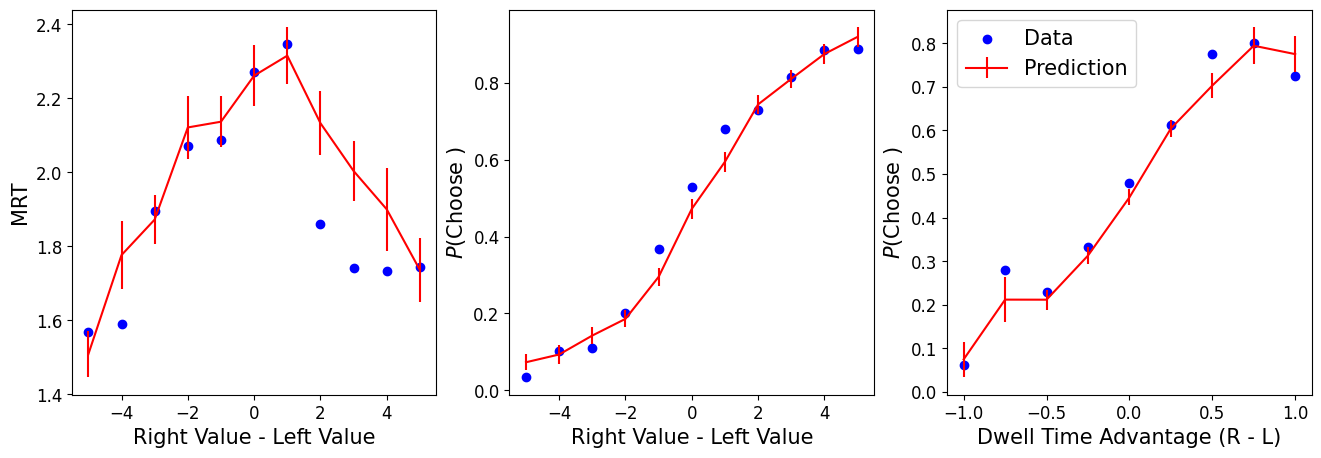

In [57]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose )');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose )');
plt.legend();

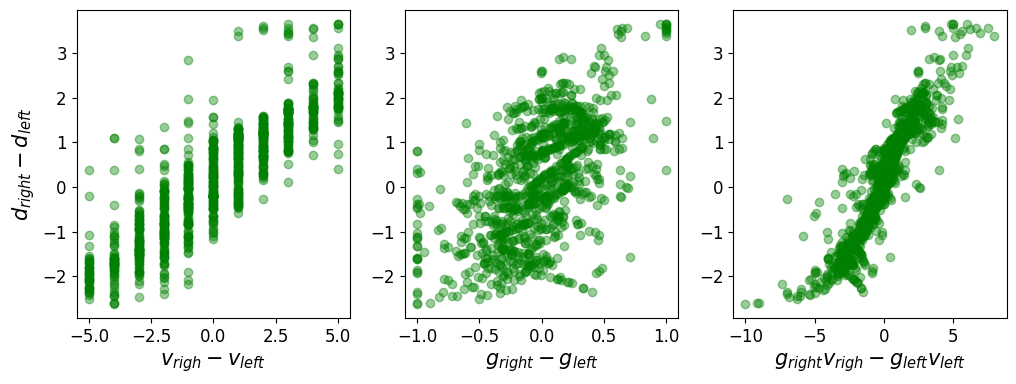

In [67]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');